In [1]:
# import libraries
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
import seaborn as sns 
from pandas import set_option
plt.style.use('ggplot') 
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import warnings
from sklearn.utils import resample
import statistics
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import scipy.stats as stats
from scipy.stats import chi2

/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jdanielkim123/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
#importing the data
df = pd.read_csv("default_data.csv", header=1)
df.drop(['0','ID'],axis=1,inplace=True)

In [3]:
#Chi Squared tests
def Chi_squared_test(socio_dem, default):
    dataset_tables = pd.crosstab(socio_dem,default)
    observed_values = dataset_tables.values
    val=stats.chi2_contingency(dataset_tables)
    Exp_val = val[3]
    no_of_rows = len(dataset_tables.iloc[0:len(socio_dem),0])
    no_of_columns = len(dataset_tables.iloc[0,0:len(default)])
    ddof=(no_of_rows-1)*(no_of_columns-1)
    alpha=0.05
    chi_square=sum([(o-e)**2/e for o,e in zip(observed_values,Exp_val)])
    chi_square_statistic=chi_square[0]+chi_square[1]
    p_value = 1-chi2.cdf(x=chi_square_statistic, df=ddof)
    if p_value < 0.05: 
        print('Dependent and the p-value is', p_value)
    else: 
        print('Independent and the p-value is', p_value)

In [4]:
#Checking to see if all of the data fits well with the Cook Book
df['SEX'].value_counts()
#In education we notice that there are additional variables 0,5,6
df['EDUCATION'].value_counts()
#In marriage we notice that there is an additional variable 0
df['MARRIAGE'].value_counts()
df['AGE'].value_counts()
#In PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6, we notice that there is an additional variable -2, but we will assume that means payments made in advance
df['PAY_0'].value_counts()
df['PAY_2'].value_counts()
df['PAY_3'].value_counts()
df['PAY_4'].value_counts()
df['PAY_5'].value_counts()
df['PAY_6'].value_counts()
df['BILL_AMT1'].value_counts()
df['BILL_AMT2'].value_counts()
df['BILL_AMT3'].value_counts()
df['BILL_AMT4'].value_counts()
df['BILL_AMT5'].value_counts()
df['BILL_AMT6'].value_counts()
df['PAY_AMT1'].value_counts()
df['PAY_AMT2'].value_counts()
df['PAY_AMT3'].value_counts()
df['PAY_AMT4'].value_counts()
df['PAY_AMT5'].value_counts()
df['PAY_AMT6'].value_counts()
df['default payment next month'].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

# Monthly: FX vs payment vs Bills 

In [5]:
df.rename(columns={'default payment next month':'default'},inplace=True)
data =df.astype(float)
#Since the highest level of education is 4 we group anything above that into 4 since 4 is others. Since the lowest category is 1 anything under that we grouped into 4 since 4 is others. . 
data['EDUCATION']=np.where(data['EDUCATION']>4,4,data['EDUCATION'])
data['EDUCATION']=np.where(data['EDUCATION']<1,4,data['EDUCATION'])
#Since the lowest categorization of MARRIAGE is 1, we group the 0's into the the others catagroy (3).
data['MARRIAGE']=np.where(data['MARRIAGE']<1,3,data['MARRIAGE'])
data = pd.get_dummies(data, columns=['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
        'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'],drop_first=True)
X = data.drop('default', axis = 1) 
y = data['default'] 
X_noage =X.drop(['AGE'], axis = 1) 
X_nosex =X.drop('SEX_2.0', axis = 1) 
X_noeducation =X.drop(['EDUCATION_2.0',
       'EDUCATION_3.0', 'EDUCATION_4.0'], axis = 1) 
X_nomarriage =X.drop(['MARRIAGE_2.0', 'MARRIAGE_3.0'], axis = 1) 

In [6]:
gdp_monthly = pd.read_csv('EXTAUS.csv')[270:276]
gdp_monthly = gdp_monthly.drop('DATE',axis=1)
gdp_monthly = (gdp_monthly-gdp_monthly.min())/(gdp_monthly.max()-gdp_monthly.min())
gdp_monthly.reset_index(inplace=True)

In [7]:
bills = []
for i in df[['BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].mean():
    bills.append(i)

In [8]:
bills.reverse()
bills = pd.DataFrame(bills)
bills.rename(columns={0:'bills'},inplace=True)
bills = (bills-bills.min())/(bills.max()-bills.min())

In [9]:
payment = []
for i in df[['PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].mean():
    payment.append(i)

In [10]:
payment.reverse()
payment = pd.DataFrame(payment)
payment.rename(columns={0:'payment'},inplace=True)
payment = (payment-payment.min())/(payment.max()-payment.min())

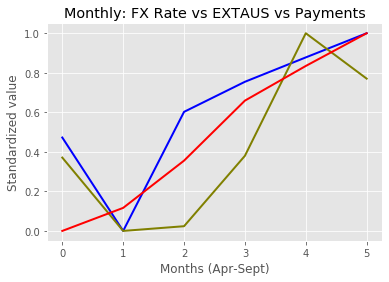

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.title('Monthly: FX Rate vs EXTAUS vs Payments')
plt.xlabel('Months (Apr-Sept)')
plt.ylabel('Standardized value')
plt.plot( 'EXTAUS', data=gdp_monthly, marker='', color='blue', linewidth=2)
plt.plot( 'payment', data=payment, marker='', color='olive', linewidth=2)
plt.plot( 'bills', data=bills, marker='', color='red', linewidth=2);

## Chi Squared tests

Ho: The socio-demographic variable is independent of defaulting 

Ha: The socio-demographic variable is dependent of defaulting

In [12]:
Chi_squared_test( df['SEX'],df['default'])

Dependent and the p-value is 4.472755499307368e-12


In [13]:
Chi_squared_test( df['MARRIAGE'],df['default'])

Dependent and the p-value is 8.825862463091028e-08


In [14]:
Chi_squared_test(df['EDUCATION'],df['default'])

Dependent and the p-value is 0.0


In [15]:
Chi_squared_test(df['AGE'],df['default'])

Dependent and the p-value is 5.643041589564746e-12


# Sorting Smoothing Method and R^2 functions

In [16]:
#Sliding windows for the Sorting Smoothing Method
def dataframe(y_test, listsdf):
    ydf=pd.DataFrame(y_test)
    ydf.reset_index(inplace=True)
    concat = pd.concat([ydf,listsdf],axis=1)
    concat.drop(['index',0],axis=1,inplace=True)
    concat.rename(columns={1:'predicted'},inplace=True)
    dataframe = concat.sort_values('predicted', axis=0, ascending=True)
    dataframe.reset_index(inplace=True)
    dataframe.drop('index',axis=1,inplace=True)
    setting =[]
    i=50
    z=0
    while i < len(dataframe):
        j = sum(dataframe['default'][z:i])/101
        setting.append(j)
        i+=1
        z+=1
    sliding = pd.DataFrame(setting).shift(50)
    concating_2 = pd.concat([dataframe,sliding],axis=1)
    concating_2.dropna(inplace=True)
    concating_2.rename(columns={0:'Actual'},inplace=True)
    concating_2.reset_index(inplace=True)
    concating_2
    return concating_2

In [17]:
def r_squared(x,y):
    numerator = np.sum(((x)-(y))**2)
    denominator = np.sum(((x.mean())-(y))**2)
    return(1-(numerator/denominator))

## Logistical regression with all variables


In [128]:
#Fitting the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23 )
training = pd.concat([X_train,y_train],axis=1)
testing = pd.concat([X_test,y_test],axis=1)
lr = LogisticRegression( solver='liblinear', class_weight='balanced')
lr.fit(X_train, y_train)
THRESHOLD =.5
test = np.where(lr.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print('Test Accuracy score: ', accuracy_score(y_test, test))
print('Test F1 score: ', f1_score(y_test, test))

Test Accuracy score:  0.7252222222222222
Test F1 score:  0.4878856906191759


In [129]:
#Apply the SSM
listsdf = pd.DataFrame(lr.predict_proba(X_test))
Logistical_regression_df = dataframe(y_test,listsdf)

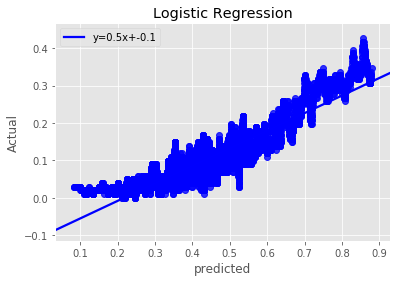

In [130]:
#Plotting scatterplot to generate the linear regression for R^2
slope, intercept, r_value, p_value, std_err = stats.linregress(Logistical_regression_df["predicted"],Logistical_regression_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=Logistical_regression_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
plt.title('Logistic Regression')
ax.legend()
plt.show()

In [21]:
#Calculating R^2 values
Logistical_regression_df['regressor'] = Logistical_regression_df['predicted'].map(lambda x: (0.5*x)-.1)
print('R^2:',r_squared(Logistical_regression_df['regressor'],Logistical_regression_df['Actual']))

R^2: 0.8009219022749912


# Logistical Regression without age variable

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_noage, y, test_size=0.3, random_state=23 )
training = pd.concat([X_train,y_train],axis=1)
testing = pd.concat([X_test,y_test],axis=1)
lr = LogisticRegression( solver='liblinear')
lr.fit(X_train, y_train)
THRESHOLD =.5
test = np.where(lr.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print('Test Accuracy score: ', accuracy_score(y_test, test))
print('Test F1 score: ', f1_score(y_test, test))

Test Accuracy score:  0.7788888888888889
Test F1 score:  0.0


In [23]:
listsdf = pd.DataFrame(lr.predict_proba(X_test))
Logistical_regression_df = dataframe(y_test,listsdf)

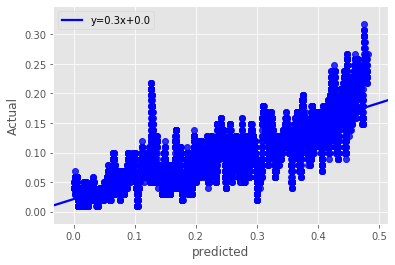

In [24]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Logistical_regression_df["predicted"],Logistical_regression_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=Logistical_regression_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [25]:
Logistical_regression_df['regressor'] = Logistical_regression_df['predicted'].map(lambda x: (.3*x))
print('R^2:',r_squared(Logistical_regression_df['regressor'],Logistical_regression_df['Actual']))

R^2: 0.508327139326989


# Logistical Regression without marriage variable

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_nomarriage, y, test_size=0.3, random_state=23 )
training = pd.concat([X_train,y_train],axis=1)
testing = pd.concat([X_test,y_test],axis=1)
lr = LogisticRegression( solver='liblinear')
lr.fit(X_train, y_train)
THRESHOLD =.5
test = np.where(lr.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print('Test Accuracy score: ', accuracy_score(y_test, test))
print('Test F1 score: ', f1_score(y_test, test))

Test Accuracy score:  0.779
Test F1 score:  0.0


In [27]:
listsdf = pd.DataFrame(lr.predict_proba(X_test))
Logistical_regression_df = dataframe(y_test,listsdf)

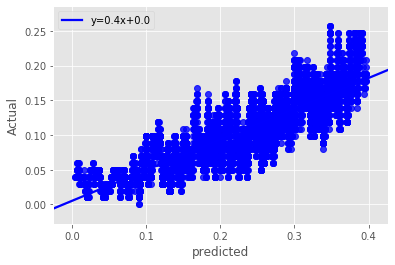

In [28]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Logistical_regression_df["predicted"],Logistical_regression_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=Logistical_regression_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [29]:
Logistical_regression_df['regressor'] = Logistical_regression_df['predicted'].map(lambda x: (.4*x))
print('R^2:',r_squared(Logistical_regression_df['regressor'],Logistical_regression_df['Actual']))

R^2: 0.6362354677265059


# Logistical Regression without education variable

In [30]:
X_noeducation
X_train, X_test, y_train, y_test = train_test_split(X_noeducation, y, test_size=0.3, random_state=23 )
training = pd.concat([X_train,y_train],axis=1)
testing = pd.concat([X_test,y_test],axis=1)
lr = LogisticRegression( solver='liblinear', class_weight='balanced')
lr.fit(X_train, y_train)
THRESHOLD =.5
test = np.where(lr.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print('Test Accuracy score: ', accuracy_score(y_test, test))
print('Test F1 score: ', f1_score(y_test, test))

Test Accuracy score:  0.7227777777777777
Test F1 score:  0.48332988196313936


In [31]:
listsdf = pd.DataFrame(lr.predict_proba(X_test))
Logistical_regression_df = dataframe(y_test,listsdf)

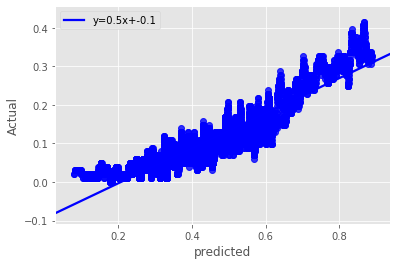

In [32]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Logistical_regression_df["predicted"],Logistical_regression_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=Logistical_regression_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [33]:
Logistical_regression_df['regressor'] = Logistical_regression_df['predicted'].map(lambda x: (x*.5)-.1)
print('R^2:',r_squared(Logistical_regression_df['regressor'],Logistical_regression_df['Actual']))

R^2: 0.8155365684111853


# Logistical Regression without Sex variable 

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_nosex, y, test_size=0.3, random_state=23 )
training = pd.concat([X_train,y_train],axis=1)
testing = pd.concat([X_test,y_test],axis=1)
lr = LogisticRegression( solver='liblinear', class_weight='balanced')
lr.fit(X_train, y_train)
THRESHOLD =.5
test = np.where(lr.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print('Test Accuracy score: ', accuracy_score(y_test, test))
print('Test F1 score: ', f1_score(y_test, test))

Test Accuracy score:  0.6756666666666666
Test F1 score:  0.46878980891719746


In [35]:
listsdf = pd.DataFrame(lr.predict_proba(X_test))
Logistical_regression_df = dataframe(y_test,listsdf)

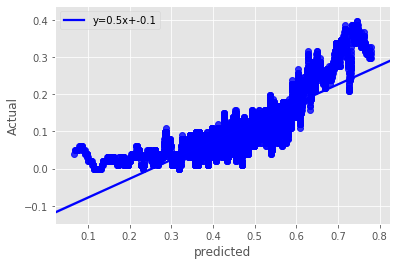

In [36]:
slope, intercept, r_value, p_value, std_err = stats.linregress(Logistical_regression_df["predicted"],Logistical_regression_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=Logistical_regression_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [37]:
Logistical_regression_df['regressor'] = Logistical_regression_df['predicted'].map(lambda x: (.5*x)-.1)
print('R^2:',r_squared(Logistical_regression_df['regressor'],Logistical_regression_df['Actual']))

R^2: 0.6436942427730239


## KNN

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23 )
training = pd.concat([X_train,y_train],axis=1)
testing = pd.concat([X_test,y_test],axis=1)
knn = KNeighborsClassifier(n_neighbors=55)
knn.fit(X_train, y_train)
THRESHOLD=0.5
y_pred = np.where(knn.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
acc = metrics.accuracy_score(y_test, y_pred)
print('Test Accuracy score: ',acc)
print('Test F1 score: ', f1_score(y_test, y_pred))

Test Accuracy score:  0.78
Test F1 score:  0.13385826771653545


In [136]:
listsdf_knn = pd.DataFrame(knn.predict_proba(X_test))
KNN_df = dataframe(y_test,listsdf_knn)

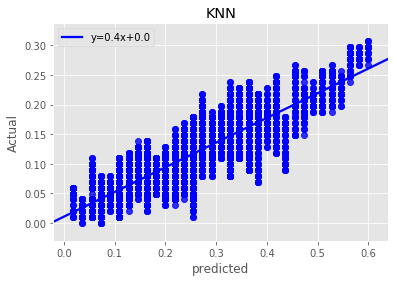

In [137]:
slope, intercept, r_value, p_value, std_err = stats.linregress(KNN_df["predicted"],KNN_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=KNN_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
plt.title('KNN')
ax.legend()
plt.show()

In [138]:
KNN_df['regressor'] = KNN_df['predicted'].map(lambda x: (.4*x))
print('R^2:',r_squared(KNN_df['regressor'],KNN_df['Actual']))

R^2: 0.7015738370501473


# KNN No Age

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_noage, y, test_size=0.3, random_state=23 )
training = pd.concat([X_train,y_train],axis=1)
testing = pd.concat([X_test,y_test],axis=1)
knn = KNeighborsClassifier(n_neighbors=55)
knn.fit(X_train, y_train)
THRESHOLD=0.5
y_pred = np.where(knn.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
acc = metrics.accuracy_score(y_test, y_pred)
print('Test Accuracy score: ',acc)
print('Test F1 score: ', f1_score(y_test, y_pred))

Test Accuracy score:  0.781
Test F1 score:  0.1328640563132424


In [43]:
listsdf_knn = pd.DataFrame(knn.predict_proba(X_test))
KNN_df = dataframe(y_test,listsdf_knn)

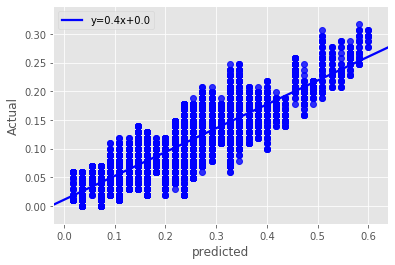

In [44]:
slope, intercept, r_value, p_value, std_err = stats.linregress(KNN_df["predicted"],KNN_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=KNN_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [45]:
KNN_df['regressor'] = KNN_df['predicted'].map(lambda x: (.4*x))
print('R^2:',r_squared(KNN_df['regressor'],KNN_df['Actual']))

R^2: 0.6984812386479148


# KNN No Sex

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_nosex, y, test_size=0.3, random_state=23 )
training = pd.concat([X_train,y_train],axis=1)
testing = pd.concat([X_test,y_test],axis=1)
knn = KNeighborsClassifier(n_neighbors=55)
knn.fit(X_train, y_train)
THRESHOLD=0.5
y_pred = np.where(knn.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
acc = metrics.accuracy_score(y_test, y_pred)
print('Test Accuracy score: ',acc)
print('Test F1 score: ', f1_score(y_test, y_pred))

Test Accuracy score:  0.78
Test F1 score:  0.13385826771653545


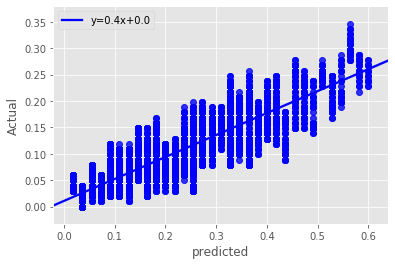

In [47]:
listsdf_knn = pd.DataFrame(knn.predict_proba(X_test))
KNN_df = dataframe(y_test,listsdf_knn)
slope, intercept, r_value, p_value, std_err = stats.linregress(KNN_df["predicted"],KNN_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=KNN_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [48]:
KNN_df['regressor'] = KNN_df['predicted'].map(lambda x: (.4*x))
print('R^2:',r_squared(KNN_df['regressor'],KNN_df['Actual']))

R^2: 0.6935793494049565


# KNN No Education

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_noeducation, y, test_size=0.3, random_state=23 )
training = pd.concat([X_train,y_train],axis=1)
testing = pd.concat([X_test,y_test],axis=1)
knn = KNeighborsClassifier(n_neighbors=55)
knn.fit(X_train, y_train)
THRESHOLD=0.5
y_pred = np.where(knn.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
acc = metrics.accuracy_score(y_test, y_pred)
print('Test Accuracy score: ',acc)
print('Test F1 score: ', f1_score(y_test, y_pred))

Test Accuracy score:  0.78
Test F1 score:  0.13385826771653545


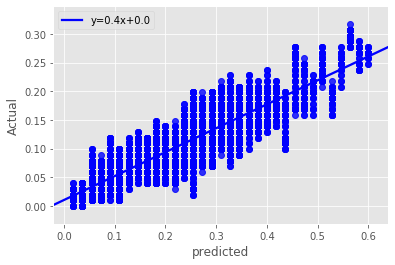

In [50]:
listsdf_knn = pd.DataFrame(knn.predict_proba(X_test))
KNN_df = dataframe(y_test,listsdf_knn)
slope, intercept, r_value, p_value, std_err = stats.linregress(KNN_df["predicted"],KNN_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=KNN_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [51]:
KNN_df['regressor'] = KNN_df['predicted'].map(lambda x: (.4*x))
print('R^2:',r_squared(KNN_df['regressor'],KNN_df['Actual']))

R^2: 0.7007537980787863


# KNN No Marriage 

Test Accuracy score:  0.78
Test F1 score:  0.13385826771653545


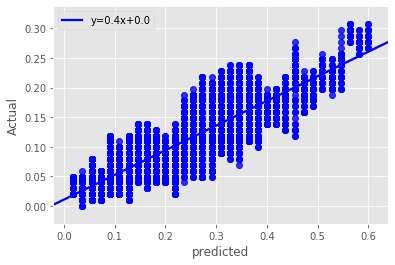

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_nomarriage, y, test_size=0.3, random_state=23 )
training = pd.concat([X_train,y_train],axis=1)
testing = pd.concat([X_test,y_test],axis=1)
knn = KNeighborsClassifier(n_neighbors=55)
knn.fit(X_train, y_train)
THRESHOLD=0.5
y_pred = np.where(knn.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
acc = metrics.accuracy_score(y_test, y_pred)
print('Test Accuracy score: ',acc)
print('Test F1 score: ', f1_score(y_test, y_pred))
listsdf_knn = pd.DataFrame(knn.predict_proba(X_test))
KNN_df = dataframe(y_test,listsdf_knn)
slope, intercept, r_value, p_value, std_err = stats.linregress(KNN_df["predicted"],KNN_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=KNN_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [53]:
KNN_df['regressor'] = KNN_df['predicted'].map(lambda x: (.4*x))
print('R^2:',r_squared(KNN_df['regressor'],KNN_df['Actual']))

R^2: 0.6924405109466432


## Decision Trees 

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23 )
dtc = DecisionTreeClassifier(random_state=1,max_depth=4, criterion= 'gini', max_leaf_nodes=5,max_features=76)
dtc.fit(X_train,y_train)
THRESHOLD=0.5
final = np.where(dtc.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print("f1:",metrics.f1_score(y_test, final))
acc = metrics.accuracy_score(y_test, final)
print('Test Accuracy score: ',acc)

f1: 0.39051094890510957
Test Accuracy score:  0.8144444444444444


In [140]:
listsdf_dtc = pd.DataFrame(dtc.predict_proba(X_test))
dtc_df = dataframe(y_test,listsdf_dtc)

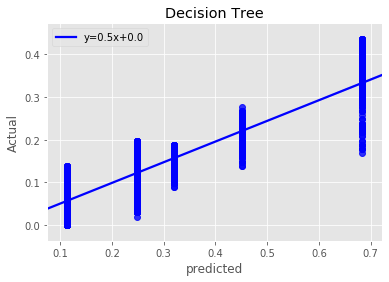

In [141]:
slope, intercept, r_value, p_value, std_err = stats.linregress(dtc_df["predicted"],dtc_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=dtc_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
plt.title('Decision Tree')
ax.legend()
plt.show()

In [142]:
dtc_df['regressor'] = dtc_df['predicted'].map(lambda x: (x*.5))
print('R^2:',r_squared(dtc_df['regressor'],dtc_df['Actual']))

R^2: 0.8884132105347244


# Decision Trees No Age 

f1: 0.39051094890510957
Test Accuracy score:  0.8144444444444444


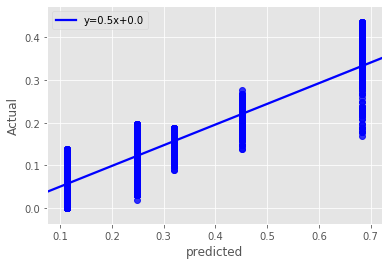

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_noage, y, test_size=0.3, random_state=23 )
dtc = DecisionTreeClassifier(random_state=1,max_depth=4, criterion= 'gini', max_leaf_nodes=5,max_features=76)
dtc.fit(X_train,y_train)
THRESHOLD=0.5
final = np.where(dtc.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print("f1:",metrics.f1_score(y_test, final))
acc = metrics.accuracy_score(y_test, final)
print('Test Accuracy score: ',acc)
listsdf_dtc = pd.DataFrame(dtc.predict_proba(X_test))
dtc_df = dataframe(y_test,listsdf_dtc)
slope, intercept, r_value, p_value, std_err = stats.linregress(dtc_df["predicted"],dtc_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=dtc_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [59]:
dtc_df['regressor'] = dtc_df['predicted'].map(lambda x: (x*.5))
print('R^2:',r_squared(dtc_df['regressor'],dtc_df['Actual']))

R^2: 0.8884132105347244


# Decision Trees No Sex

f1: 0.39051094890510957
Test Accuracy score:  0.8144444444444444


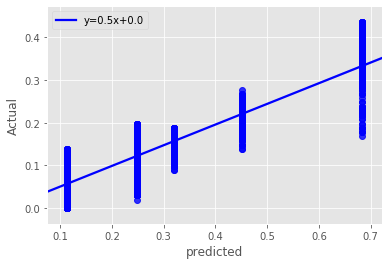

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_nosex, y, test_size=0.3, random_state=23 )
dtc = DecisionTreeClassifier(random_state=1,max_depth=4, criterion= 'gini', max_leaf_nodes=5,max_features=76)
dtc.fit(X_train,y_train)
THRESHOLD=0.5
final = np.where(dtc.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print("f1:",metrics.f1_score(y_test, final))
acc = metrics.accuracy_score(y_test, final)
print('Test Accuracy score: ',acc)
listsdf_dtc = pd.DataFrame(dtc.predict_proba(X_test))
dtc_df = dataframe(y_test,listsdf_dtc)
slope, intercept, r_value, p_value, std_err = stats.linregress(dtc_df["predicted"],dtc_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=dtc_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [61]:
dtc_df['regressor'] = dtc_df['predicted'].map(lambda x: (x*.5))
print('R^2:',r_squared(dtc_df['regressor'],dtc_df['Actual']))

R^2: 0.8884132105347244


# Decision Trees  No Education

f1: 0.39051094890510957
Test Accuracy score:  0.8144444444444444


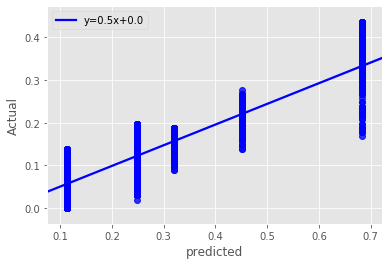

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_noeducation, y, test_size=0.3, random_state=23 )
dtc = DecisionTreeClassifier(random_state=1,max_depth=4, criterion= 'gini', max_leaf_nodes=5,max_features=75)
dtc.fit(X_train,y_train)
THRESHOLD=0.5
final = np.where(dtc.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print("f1:",metrics.f1_score(y_test, final))
acc = metrics.accuracy_score(y_test, final)
print('Test Accuracy score: ',acc)
listsdf_dtc = pd.DataFrame(dtc.predict_proba(X_test))
dtc_df = dataframe(y_test,listsdf_dtc)
slope, intercept, r_value, p_value, std_err = stats.linregress(dtc_df["predicted"],dtc_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=dtc_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [63]:
dtc_df['regressor'] = dtc_df['predicted'].map(lambda x: (x*.5))
print('R^2:',r_squared(dtc_df['regressor'],dtc_df['Actual']))

R^2: 0.8884132105347244


# Decision Trees No marriage 

f1: 0.39051094890510957
Test Accuracy score:  0.8144444444444444


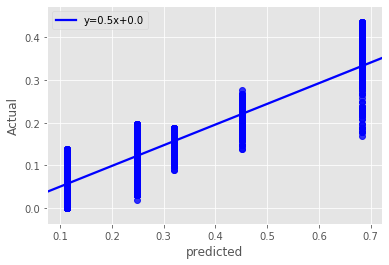

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_nomarriage, y, test_size=0.3, random_state=23 )
dtc = DecisionTreeClassifier(random_state=1,max_depth=4, criterion= 'gini', max_leaf_nodes=5,max_features=75)
dtc.fit(X_train,y_train)
THRESHOLD=0.5
final = np.where(dtc.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print("f1:",metrics.f1_score(y_test, final))
acc = metrics.accuracy_score(y_test, final)
print('Test Accuracy score: ',acc)
listsdf_dtc = pd.DataFrame(dtc.predict_proba(X_test))
dtc_df = dataframe(y_test,listsdf_dtc)
slope, intercept, r_value, p_value, std_err = stats.linregress(dtc_df["predicted"],dtc_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=dtc_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [65]:
dtc_df['regressor'] = dtc_df['predicted'].map(lambda x: (x*.5))
print('R^2:',r_squared(dtc_df['regressor'],dtc_df['Actual']))

R^2: 0.8884132105347244


# Random Forest

In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23 )
rfc1 = RandomForestClassifier(random_state=1, class_weight='balanced', n_estimators=500, max_depth = 6, max_features=50,criterion='gini')
rfc1.fit(X_train, y_train)
rfc1_preds = np.where(rfc1.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
rfc1_f1 = metrics.f1_score(y_test, rfc1_preds)
rfc1_accuracy = metrics.f1_score(y_test, rfc1_preds)
print('Test Accuracy score: ',rfc1_accuracy)
print('Test F1 score: ', rfc1_f1)


Test Accuracy score:  0.518645227505987
Test F1 score:  0.518645227505987


In [144]:
listsdf_rfc1 = pd.DataFrame(rfc1.predict_proba(X_test))
rfc1_df = dataframe(y_test,listsdf_rfc1)

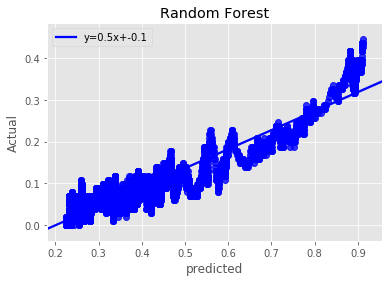

In [145]:
slope, intercept, r_value, p_value, std_err = stats.linregress(rfc1_df["predicted"],rfc1_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=rfc1_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
plt.title('Random Forest')
ax.legend()
plt.show()

In [146]:
rfc1_df['regressor'] = rfc1_df['predicted'].map(lambda x: (.5*x)-0.1)
print('R^2:',r_squared(rfc1_df['regressor'],rfc1_df['Actual']))

R^2: 0.862437022280237


# Random Forest No Age

Test Accuracy score:  0.5193447194144301
Test F1 score:  0.5193447194144301


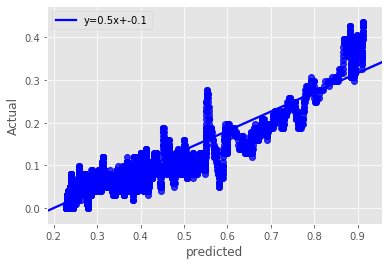

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_noage, y, test_size=0.2, random_state=23 )
rfc1 = RandomForestClassifier(random_state=1, class_weight='balanced', n_estimators=500, max_depth = 6, max_features=50,criterion='gini')
rfc1.fit(X_train, y_train)
rfc1_preds = np.where(rfc1.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
rfc1_f1 = metrics.f1_score(y_test, rfc1_preds)
rfc1_accuracy = metrics.f1_score(y_test, rfc1_preds)
print('Test Accuracy score: ',rfc1_accuracy)
print('Test F1 score: ', rfc1_f1)
listsdf_rfc1 = pd.DataFrame(rfc1.predict_proba(X_test))
rfc1_df = dataframe(y_test,listsdf_rfc1)
slope, intercept, r_value, p_value, std_err = stats.linregress(rfc1_df["predicted"],rfc1_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=rfc1_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [71]:
rfc1_df['regressor'] = rfc1_df['predicted'].map(lambda x: (.5*x)-0.1)
print('R^2:',r_squared(rfc1_df['regressor'],rfc1_df['Actual']))

R^2: 0.8574651644268704


# Random Forest No Sex

Test Accuracy score:  0.520891364902507
Test F1 score:  0.520891364902507


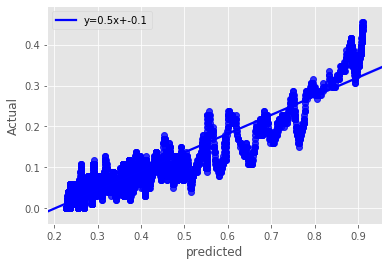

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_nosex, y, test_size=0.2, random_state=23 )
rfc1 = RandomForestClassifier(random_state=1, class_weight='balanced', n_estimators=500, max_depth = 6, max_features=50,criterion='gini')
rfc1.fit(X_train, y_train)
rfc1_preds = np.where(rfc1.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
rfc1_f1 = metrics.f1_score(y_test, rfc1_preds)
rfc1_accuracy = metrics.f1_score(y_test, rfc1_preds)
print('Test Accuracy score: ',rfc1_accuracy)
print('Test F1 score: ', rfc1_f1)
listsdf_rfc1 = pd.DataFrame(rfc1.predict_proba(X_test))
rfc1_df = dataframe(y_test,listsdf_rfc1)
slope, intercept, r_value, p_value, std_err = stats.linregress(rfc1_df["predicted"],rfc1_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=rfc1_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [73]:
rfc1_df['regressor'] = rfc1_df['predicted'].map(lambda x: (.5*x)-0.1)
print('R^2:',r_squared(rfc1_df['regressor'],rfc1_df['Actual']))

R^2: 0.8544824494200621


# Random Forest No Education

Test Accuracy score:  0.5235457063711911
Test F1 score:  0.5235457063711911


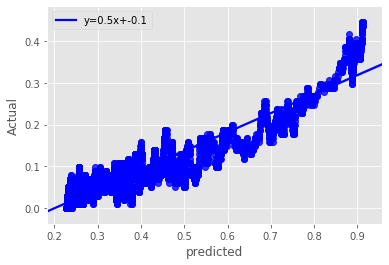

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_noeducation, y, test_size=0.2, random_state=23 )
rfc1 = RandomForestClassifier(random_state=1, class_weight='balanced', n_estimators=500, max_depth = 6, max_features=50,criterion='gini')
rfc1.fit(X_train, y_train)
rfc1_preds = np.where(rfc1.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
rfc1_f1 = metrics.f1_score(y_test, rfc1_preds)
rfc1_accuracy = metrics.f1_score(y_test, rfc1_preds)
print('Test Accuracy score: ',rfc1_accuracy)
print('Test F1 score: ', rfc1_f1)
listsdf_rfc1 = pd.DataFrame(rfc1.predict_proba(X_test))
rfc1_df = dataframe(y_test,listsdf_rfc1)
slope, intercept, r_value, p_value, std_err = stats.linregress(rfc1_df["predicted"],rfc1_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=rfc1_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [75]:
rfc1_df['regressor'] = rfc1_df['predicted'].map(lambda x: (.5*x)-0.1)
print('R^2:',r_squared(rfc1_df['regressor'],rfc1_df['Actual']))

R^2: 0.8573014042604647


# Random Forest No Marriage 

Test Accuracy score:  0.5207756232686982
Test F1 score:  0.5207756232686982


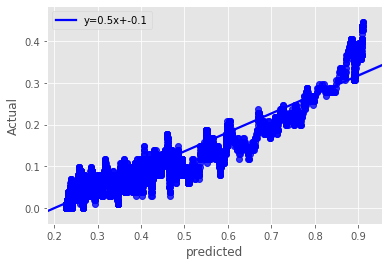

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_nomarriage, y, test_size=0.2, random_state=23 )
rfc1 = RandomForestClassifier(random_state=1, class_weight='balanced', n_estimators=500, max_depth = 6, max_features=50,criterion='gini')
rfc1.fit(X_train, y_train)
rfc1_preds = np.where(rfc1.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
rfc1_f1 = metrics.f1_score(y_test, rfc1_preds)
rfc1_accuracy = metrics.f1_score(y_test, rfc1_preds)
print('Test Accuracy score: ',rfc1_accuracy)
print('Test F1 score: ', rfc1_f1)
listsdf_rfc1 = pd.DataFrame(rfc1.predict_proba(X_test))
rfc1_df = dataframe(y_test,listsdf_rfc1)
slope, intercept, r_value, p_value, std_err = stats.linregress(rfc1_df["predicted"],rfc1_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=rfc1_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [77]:
rfc1_df['regressor'] = rfc1_df['predicted'].map(lambda x: (.5*x)-0.1)
print('R^2:',r_squared(rfc1_df['regressor'],rfc1_df['Actual']))

R^2: 0.8652130091322745


## Feature Importance

In [78]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

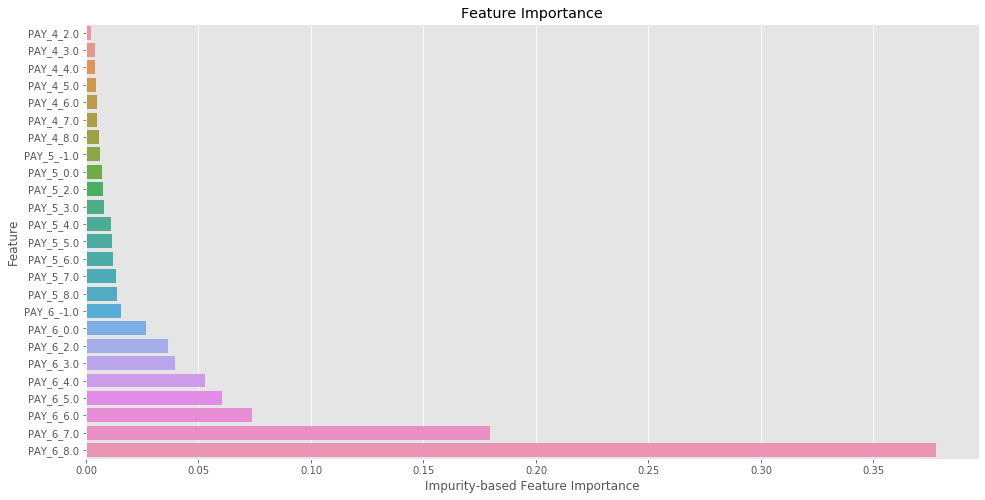

In [79]:
plt.figure(figsize=(16,8))
plt.xlabel('Impurity-based Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
sns.barplot( y=X_train.columns.values[-25: ], x=np.sort(rfc1.feature_importances_)[-25:], orient='h');

# Neural Network

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
#Resizing data to fit into the Neural network
X_train = (X_train - X_train.min())/(X_train.max()-X_train.min())
X_train.fillna(0,inplace=True)
X_test= (X_test - X_test.min())/(X_test.max()-X_test.min())
X_test.fillna(0,inplace=True)
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(78,)),
    keras.layers.Dense(20, activation=tf.nn.relu),
	keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=1)
test_loss, test_acc = model.evaluate(X_test, y_test)
THRESHOLD=0.5
y_pred = np.where(model.predict_proba(X_test)>THRESHOLD,1,0)
print('Test accuracy:', test_acc)

Epoch 1/10
21000/21000 [==============================] - 23s 1ms/sample - loss: 0.4492 - accuracy: 0.8150
Epoch 2/10
21000/21000 [==============================] - 22s 1ms/sample - loss: 0.4406 - accuracy: 0.8192
Epoch 3/10
21000/21000 [==============================] - 22s 1ms/sample - loss: 0.4385 - accuracy: 0.8203s - loss: 0.4372 -  - ETA: 
Epoch 4/10
21000/21000 [==============================] - 21s 990us/sample - loss: 0.4378 - accuracy: 0.8208
Epoch 5/10
21000/21000 [==============================] - 21s 1ms/sample - loss: 0.4360 - accuracy: 0.8210
Epoch 6/10
21000/21000 [==============================] - 22s 1ms/sample - loss: 0.4356 - accuracy: 0.8215
Epoch 7/10
21000/21000 [==============================] - 22s 1ms/sample - loss: 0.4348 - accuracy: 0.8226
Epoch 8/10
21000/21000 [==============================] - 20s 972us/sample - loss: 0.4332 - accuracy: 0.8225
Epoch 9/10
21000/21000 [==============================] - 19s 907us/sample - loss: 0.4326 - accuracy: 0.8221
Epoc

In [148]:
def dataframe_NN(y_test,listsdf_NN):
    ydf=pd.DataFrame(y_test)
    ydf.reset_index(inplace=True)
    concat = pd.concat([ydf,listsdf_NN],axis=1)
    concat.drop(['index'],axis=1,inplace=True)
    concat.rename(columns={0:'predicted'},inplace=True)
    dataframe = concat.sort_values('predicted', axis=0, ascending=True)
    dataframe.reset_index(inplace=True)
    dataframe.drop('index',axis=1,inplace=True)
    setting =[]
    i=50
    z=0
    while i < len(dataframe):
        j = sum(dataframe['default'][z:i])/101
        setting.append(j)
        i+=1
        z+=1
    sliding = pd.DataFrame(setting).shift(50)
    concating_2 = pd.concat([dataframe,sliding],axis=1)
    concating_2.dropna(inplace=True)
    concating_2.rename(columns={0:'Actual'},inplace=True)
    return concating_2

In [149]:
listsdf_NN = pd.DataFrame(model.predict_proba(X_test))
NN_df = dataframe_NN(y_test,listsdf_NN)

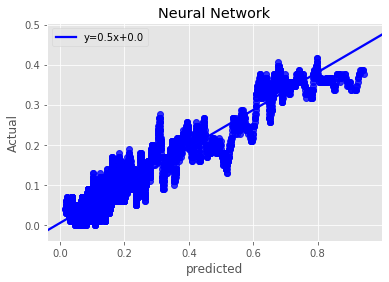

In [150]:
slope, intercept, r_value, p_value, std_err = stats.linregress(NN_df["predicted"],NN_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=NN_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
plt.title('Neural Network')

ax.legend()
plt.show()

In [84]:
NN_df['regressor'] = NN_df['predicted'].map(lambda x: (x*.5))
r_squared(NN_df['regressor'],NN_df['Actual'])

0.9034606980850719

# No Age NN

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_noage, y, test_size=0.3, random_state=0)
X_train = (X_train - X_train.min())/(X_train.max()-X_train.min())
X_train.fillna(0,inplace=True)
X_test= (X_test - X_test.min())/(X_test.max()-X_test.min())
X_test.fillna(0,inplace=True)
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(77,)),
    keras.layers.Dense(20, activation=tf.nn.relu),
	keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=1)
test_loss, test_acc = model.evaluate(X_test, y_test)
THRESHOLD=0.5
y_pred = np.where(model.predict_proba(X_test)>THRESHOLD,1,0)
print('Test accuracy:', test_acc)

Epoch 1/10
21000/21000 [==============================] - 21s 996us/sample - loss: 0.4489 - accuracy: 0.8144
Epoch 2/10
21000/21000 [==============================] - 19s 885us/sample - loss: 0.4390 - accuracy: 0.8199
Epoch 3/10
21000/21000 [==============================] - 24s 1ms/sample - loss: 0.4377 - accuracy: 0.8202
Epoch 4/10
21000/21000 [==============================] - 20s 956us/sample - loss: 0.4373 - accuracy: 0.8215
Epoch 5/10
21000/21000 [==============================] - 19s 894us/sample - loss: 0.4351 - accuracy: 0.8230
Epoch 6/10
21000/21000 [==============================] - 18s 867us/sample - loss: 0.4344 - accuracy: 0.8219
Epoch 7/10
21000/21000 [==============================] - 18s 874us/sample - loss: 0.4337 - accuracy: 0.8231
Epoch 8/10
21000/21000 [==============================] - 18s 848us/sample - loss: 0.4329 - accuracy: 0.8226
Epoch 9/10
21000/21000 [==============================] - 18s 864us/sample - loss: 0.4320 - accuracy: 0.8238
Epoch 10/10
9000/9000

In [86]:
listsdf_NN = pd.DataFrame(model.predict_proba(X_test))
NN_df = dataframe_NN(y_test,listsdf_NN)

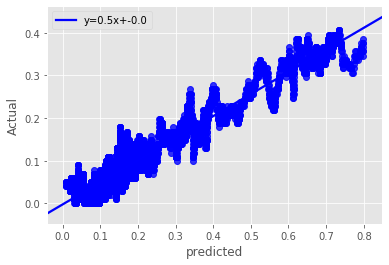

In [87]:
slope, intercept, r_value, p_value, std_err = stats.linregress(NN_df["predicted"],NN_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=NN_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [88]:
NN_df['regressor'] = NN_df['predicted'].map(lambda x: (x*.4))
r_squared(NN_df['regressor'],NN_df['Actual'])

0.8320211011765355

# No Sex NN

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_noage, y, test_size=0.3, random_state=0)
X_train = (X_train - X_train.min())/(X_train.max()-X_train.min())
X_train.fillna(0,inplace=True)
X_test= (X_test - X_test.min())/(X_test.max()-X_test.min())
X_test.fillna(0,inplace=True)
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(77,)),
    keras.layers.Dense(20, activation=tf.nn.relu),
	keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=1)
test_loss, test_acc = model.evaluate(X_test, y_test)
THRESHOLD=0.5
y_pred = np.where(model.predict_proba(X_test)>THRESHOLD,1,0)
print('Test accuracy:', test_acc)

Epoch 1/10
21000/21000 [==============================] - 19s 908us/sample - loss: 0.4478 - accuracy: 0.8145
Epoch 2/10
21000/21000 [==============================] - 23s 1ms/sample - loss: 0.4398 - accuracy: 0.8207
Epoch 3/10
21000/21000 [==============================] - 25s 1ms/sample - loss: 0.4382 - accuracy: 0.8204
Epoch 4/10
21000/21000 [==============================] - 19s 924us/sample - loss: 0.4369 - accuracy: 0.8210
Epoch 5/10
21000/21000 [==============================] - 22s 1ms/sample - loss: 0.4353 - accuracy: 0.8220
Epoch 6/10
21000/21000 [==============================] - 18s 860us/sample - loss: 0.4347 - accuracy: 0.8216
Epoch 7/10
21000/21000 [==============================] - 17s 825us/sample - loss: 0.4340 - accuracy: 0.8240
Epoch 8/10
21000/21000 [==============================] - 18s 868us/sample - loss: 0.4321 - accuracy: 0.8232
Epoch 9/10
21000/21000 [==============================] - 19s 907us/sample - loss: 0.4317 - accuracy: 0.8224
Epoch 10/10
9000/9000 [==

In [90]:
listsdf_NN = pd.DataFrame(model.predict_proba(X_test))
NN_df = dataframe_NN(y_test,listsdf_NN)

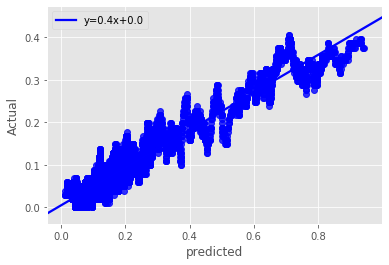

In [91]:
slope, intercept, r_value, p_value, std_err = stats.linregress(NN_df["predicted"],NN_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=NN_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [92]:
NN_df['regressor'] = NN_df['predicted'].map(lambda x: (x*.5))
r_squared(NN_df['regressor'],NN_df['Actual'])

0.8919384362759819

# No Education NN

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_noeducation, y, test_size=0.3, random_state=0)
X_train = (X_train - X_train.min())/(X_train.max()-X_train.min())
X_train.fillna(0,inplace=True)
X_test= (X_test - X_test.min())/(X_test.max()-X_test.min())
X_test.fillna(0,inplace=True)
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(75,)),
    keras.layers.Dense(20, activation=tf.nn.relu),
	keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=1)
test_loss, test_acc = model.evaluate(X_test, y_test)
THRESHOLD=0.5
y_pred = np.where(model.predict_proba(X_test)>THRESHOLD,1,0)
print('Test accuracy:', test_acc)

Epoch 1/10
21000/21000 [==============================] - 18s 874us/sample - loss: 0.4496 - accuracy: 0.8148
Epoch 2/10
21000/21000 [==============================] - 22s 1ms/sample - loss: 0.4409 - accuracy: 0.8200
Epoch 3/10
21000/21000 [==============================] - 21s 981us/sample - loss: 0.4397 - accuracy: 0.8195
Epoch 4/10
21000/21000 [==============================] - 18s 880us/sample - loss: 0.4377 - accuracy: 0.8212
Epoch 5/10
21000/21000 [==============================] - 18s 835us/sample - loss: 0.4370 - accuracy: 0.8205
Epoch 6/10
21000/21000 [==============================] - 18s 868us/sample - loss: 0.4360 - accuracy: 0.8215
Epoch 7/10
21000/21000 [==============================] - 18s 841us/sample - loss: 0.4347 - accuracy: 0.8212
Epoch 8/10
21000/21000 [==============================] - 17s 812us/sample - loss: 0.4347 - accuracy: 0.8209
Epoch 9/10
21000/21000 [==============================] - 17s 817us/sample - loss: 0.4334 - accuracy: 0.8218
Epoch 10/10
9000/9000

In [94]:
listsdf_NN = pd.DataFrame(model.predict_proba(X_test))
NN_df = dataframe_NN(y_test,listsdf_NN)

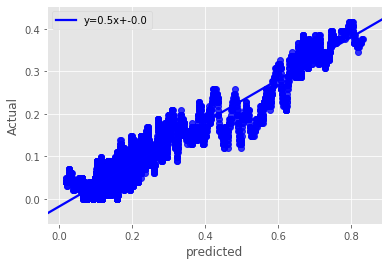

In [95]:
slope, intercept, r_value, p_value, std_err = stats.linregress(NN_df["predicted"],NN_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=NN_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [96]:
NN_df['regressor'] = NN_df['predicted'].map(lambda x: (x*.4))
r_squared(NN_df['regressor'],NN_df['Actual'])

0.8749829060502297

# No Marriage NN

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_nomarriage, y, test_size=0.3, random_state=0)
X_train = (X_train - X_train.min())/(X_train.max()-X_train.min())
X_train.fillna(0,inplace=True)
X_test= (X_test - X_test.min())/(X_test.max()-X_test.min())
X_test.fillna(0,inplace=True)
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(76,)),
    keras.layers.Dense(20, activation=tf.nn.relu),
	keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=1)
test_loss, test_acc = model.evaluate(X_test, y_test)
THRESHOLD=0.5
y_pred = np.where(model.predict_proba(X_test)>THRESHOLD,1,0)
print('Test accuracy:', test_acc)

Epoch 1/10
21000/21000 [==============================] - 19s 892us/sample - loss: 0.4489 - accuracy: 0.8154
Epoch 2/10
21000/21000 [==============================] - 18s 846us/sample - loss: 0.4408 - accuracy: 0.8189
Epoch 3/10
21000/21000 [==============================] - 18s 879us/sample - loss: 0.4391 - accuracy: 0.8198
Epoch 4/10
21000/21000 [==============================] - 18s 865us/sample - loss: 0.4375 - accuracy: 0.8201
Epoch 5/10
21000/21000 [==============================] - 19s 909us/sample - loss: 0.4365 - accuracy: 0.8199
Epoch 6/10
21000/21000 [==============================] - 18s 864us/sample - loss: 0.4358 - accuracy: 0.8198
Epoch 7/10
21000/21000 [==============================] - 18s 857us/sample - loss: 0.4349 - accuracy: 0.8215
Epoch 8/10
21000/21000 [==============================] - 18s 876us/sample - loss: 0.4342 - accuracy: 0.8227
Epoch 9/10
21000/21000 [==============================] - 19s 892us/sample - loss: 0.4327 - accuracy: 0.8220
Epoch 10/10
9000/90

In [98]:
listsdf_NN = pd.DataFrame(model.predict_proba(X_test))
NN_df = dataframe_NN(y_test,listsdf_NN)

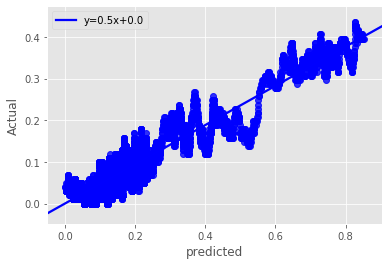

In [99]:
slope, intercept, r_value, p_value, std_err = stats.linregress(NN_df["predicted"],NN_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=NN_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [100]:
NN_df['regressor'] = NN_df['predicted'].map(lambda x: (x*.5))
r_squared(NN_df['regressor'],NN_df['Actual'])

0.903544687736205

# Naive Bayes


In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_predict = np.where(gnb.predict_proba(X_test)>THRESHOLD,1,0)

In [152]:
listsdf_gnb = pd.DataFrame(gnb.predict_proba(X_test))
gnb_df = dataframe(y_test,listsdf_gnb)

In [153]:
print("f1:",metrics.f1_score(y_test, y_pred))
acc = metrics.accuracy_score(y_test, y_pred)
print('Test Accuracy score: ',acc)

f1: 0.4690117252931324
Test Accuracy score:  0.8238888888888889


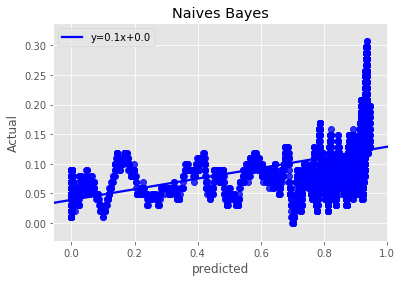

In [154]:
slope, intercept, r_value, p_value, std_err = stats.linregress(gnb_df["predicted"],gnb_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=gnb_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
plt.title('Naives Bayes')

ax.legend()
plt.show()

In [105]:
gnb_df['regressor'] = gnb_df['predicted'].map(lambda x: (x*.1))
r_squared(gnb_df['regressor'],gnb_df['Actual'])

0.19269718246522172

# Naive Bayes No Age

f1: 0.4621676891615542
Test Accuracy score:  0.8246666666666667


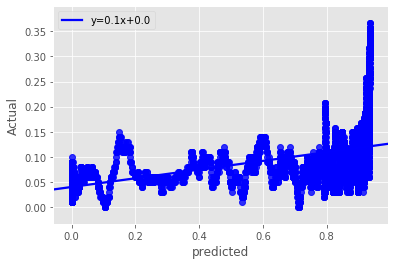

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_noage, y, test_size=0.3, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_predict = np.where(gnb.predict_proba(X_test)>THRESHOLD,1,0)
listsdf_gnb = pd.DataFrame(gnb.predict_proba(X_test))
gnb_df = dataframe(y_test,listsdf_gnb)
print("f1:",metrics.f1_score(y_test, y_pred))
acc = metrics.accuracy_score(y_test, y_pred)
print('Test Accuracy score: ',acc)
slope, intercept, r_value, p_value, std_err = stats.linregress(gnb_df["predicted"],gnb_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=gnb_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [107]:
gnb_df['regressor'] = gnb_df['predicted'].map(lambda x: (x*.1))
r_squared(gnb_df['regressor'],gnb_df['Actual'])

0.16077904542627774

# Naive Bayes No Sex

f1: 0.4621676891615542
Test Accuracy score:  0.8246666666666667


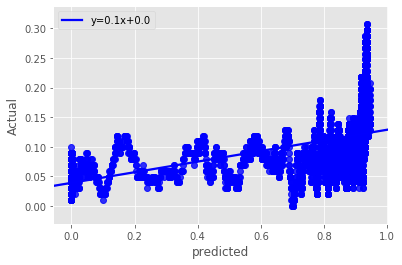

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_nosex, y, test_size=0.3, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_predict = np.where(gnb.predict_proba(X_test)>THRESHOLD,1,0)
listsdf_gnb = pd.DataFrame(gnb.predict_proba(X_test))
gnb_df = dataframe(y_test,listsdf_gnb)
print("f1:",metrics.f1_score(y_test, y_pred))
acc = metrics.accuracy_score(y_test, y_pred)
print('Test Accuracy score: ',acc)
slope, intercept, r_value, p_value, std_err = stats.linregress(gnb_df["predicted"],gnb_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=gnb_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [109]:
gnb_df['regressor'] = gnb_df['predicted'].map(lambda x: (x*.1))
r_squared(gnb_df['regressor'],gnb_df['Actual'])

0.1937176750838845

# Naive Bayes No Education 

f1: 0.4621676891615542
Test Accuracy score:  0.8246666666666667


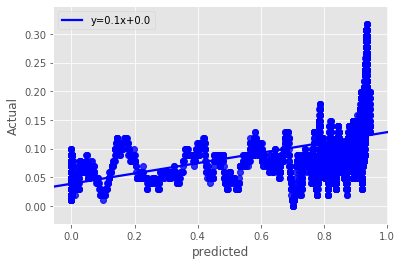

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_noeducation, y, test_size=0.3, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_predict = np.where(gnb.predict_proba(X_test)>THRESHOLD,1,0)
listsdf_gnb = pd.DataFrame(gnb.predict_proba(X_test))
gnb_df = dataframe(y_test,listsdf_gnb)
print("f1:",metrics.f1_score(y_test, y_pred))
acc = metrics.accuracy_score(y_test, y_pred)
print('Test Accuracy score: ',acc)
slope, intercept, r_value, p_value, std_err = stats.linregress(gnb_df["predicted"],gnb_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=gnb_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [111]:
gnb_df['regressor'] = gnb_df['predicted'].map(lambda x: (x*.1))
r_squared(gnb_df['regressor'],gnb_df['Actual'])

0.19425947794462517

# Naive Bayes No Marriage

f1: 0.4621676891615542
Test Accuracy score:  0.8246666666666667


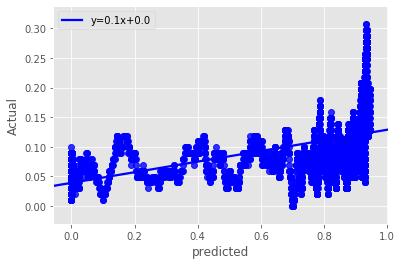

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_nomarriage, y, test_size=0.3, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_predict = np.where(gnb.predict_proba(X_test)>THRESHOLD,1,0)
listsdf_gnb = pd.DataFrame(gnb.predict_proba(X_test))
gnb_df = dataframe(y_test,listsdf_gnb)
print("f1:",metrics.f1_score(y_test, y_pred))
acc = metrics.accuracy_score(y_test, y_pred)
print('Test Accuracy score: ',acc)
slope, intercept, r_value, p_value, std_err = stats.linregress(gnb_df["predicted"],gnb_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=gnb_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [113]:
gnb_df['regressor'] = gnb_df['predicted'].map(lambda x: (x*.1))
r_squared(gnb_df['regressor'],gnb_df['Actual'])

0.19333073803389855

# Discriminent Analysis

In [155]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)
LinearDiscriminantAnalysis()
clf_pred = np.where(clf.predict_proba(X_test)[:,1]>THRESHOLD,1,0)


In [156]:
print("f1:",metrics.f1_score(y_test, clf_pred))
acc = metrics.accuracy_score(y_test, clf_pred)
print('Test Accuracy score: ',acc)

f1: 0.4749340369393141
Test Accuracy score:  0.8231111111111111


In [157]:
listsdf_clf = pd.DataFrame(clf.predict_proba(X_test))
clf_df = dataframe(y_test,listsdf_clf)

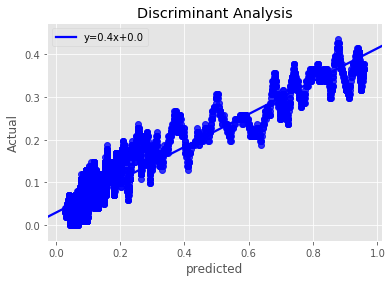

In [158]:
slope, intercept, r_value, p_value, std_err = stats.linregress(clf_df["predicted"],clf_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=clf_df, color='b', 
                 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
plt.title('Discriminant Analysis')
ax.legend()
plt.show()

In [159]:
clf_df['regressor'] = clf_df['predicted'].map(lambda x: (x*.4))
r_squared(clf_df['regressor'],clf_df['Actual'])

0.8325849915326151

# Discriminent Analysis No Age 

f1: 0.47458745874587455
Test Accuracy score:  0.8231111111111111


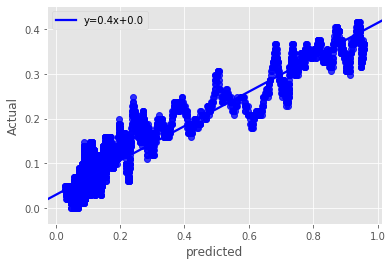

In [119]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_train, X_test, y_train, y_test = train_test_split(X_noage, y, test_size=0.3, random_state=0)
clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)
LinearDiscriminantAnalysis()
clf_pred = np.where(clf.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print("f1:",metrics.f1_score(y_test, clf_pred))
acc = metrics.accuracy_score(y_test, clf_pred)
print('Test Accuracy score: ',acc)
listsdf_clf = pd.DataFrame(clf.predict_proba(X_test))
clf_df = dataframe(y_test,listsdf_clf)
slope, intercept, r_value, p_value, std_err = stats.linregress(clf_df["predicted"],clf_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=clf_df, color='b', 
                 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [120]:
clf_df['regressor'] = clf_df['predicted'].map(lambda x: (x*.4))
r_squared(clf_df['regressor'],clf_df['Actual'])

0.8389029203663949

# Discriminent Analysis No Sex

f1: 0.4759393539881345
Test Accuracy score:  0.8233333333333334


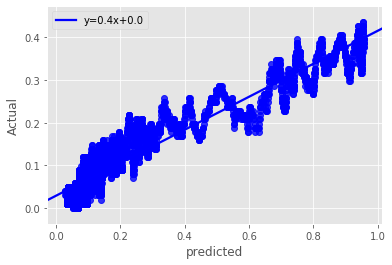

In [121]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_train, X_test, y_train, y_test = train_test_split(X_nosex, y, test_size=0.3, random_state=0)
clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)
LinearDiscriminantAnalysis()
clf_pred = np.where(clf.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print("f1:",metrics.f1_score(y_test, clf_pred))
acc = metrics.accuracy_score(y_test, clf_pred)
print('Test Accuracy score: ',acc)
listsdf_clf = pd.DataFrame(clf.predict_proba(X_test))
clf_df = dataframe(y_test,listsdf_clf)
slope, intercept, r_value, p_value, std_err = stats.linregress(clf_df["predicted"],clf_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=clf_df, color='b', 
                 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [122]:
clf_df['regressor'] = clf_df['predicted'].map(lambda x: (x*.4))
r_squared(clf_df['regressor'],clf_df['Actual'])

0.8410074108278157

# Discriminent Analysis No Education 

f1: 0.4763792533861909
Test Accuracy score:  0.8238888888888889


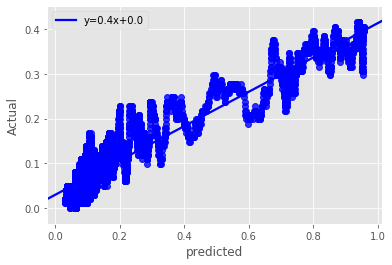

In [123]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_train, X_test, y_train, y_test = train_test_split(X_noeducation, y, test_size=0.3, random_state=0)
clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)
LinearDiscriminantAnalysis()
clf_pred = np.where(clf.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print("f1:",metrics.f1_score(y_test, clf_pred))
acc = metrics.accuracy_score(y_test, clf_pred)
print('Test Accuracy score: ',acc)
listsdf_clf = pd.DataFrame(clf.predict_proba(X_test))
clf_df = dataframe(y_test,listsdf_clf)
slope, intercept, r_value, p_value, std_err = stats.linregress(clf_df["predicted"],clf_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=clf_df, color='b', 
                 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [124]:
clf_df['regressor'] = clf_df['predicted'].map(lambda x: (x*.4))
r_squared(clf_df['regressor'],clf_df['Actual'])

0.8248421019704065

# Discriminent Analysis No Marriage 

f1: 0.47710049423393736
Test Accuracy score:  0.8236666666666667


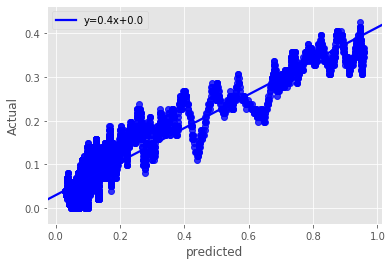

In [125]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_train, X_test, y_train, y_test = train_test_split(X_nomarriage, y, test_size=0.3, random_state=0)
clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)
LinearDiscriminantAnalysis()
clf_pred = np.where(clf.predict_proba(X_test)[:,1]>THRESHOLD,1,0)
print("f1:",metrics.f1_score(y_test, clf_pred))
acc = metrics.accuracy_score(y_test, clf_pred)
print('Test Accuracy score: ',acc)
listsdf_clf = pd.DataFrame(clf.predict_proba(X_test))
clf_df = dataframe(y_test,listsdf_clf)
slope, intercept, r_value, p_value, std_err = stats.linregress(clf_df["predicted"],clf_df["Actual"])
ax = sns.regplot(x="predicted", y="Actual", data=clf_df, color='b', 
                 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()
plt.show()

In [126]:
clf_df['regressor'] = clf_df['predicted'].map(lambda x: (x*.4))
r_squared(clf_df['regressor'],clf_df['Actual'])

0.8272585964051833